<a href="https://colab.research.google.com/github/YounSooKimTech/Joy_NLP_Power/blob/main/src/Results_TimeDelta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/YounSooKimTech/Joy_NLP_Power/main/data/Enron_merged_df.csv')
df.fillna('', inplace=True)

In [3]:

df_re = df[df["Subject"].str.startswith("RE:")]
df_re = df_re.reset_index(drop=True)

print(df.shape, df_re.shape)

(2021, 20) (73, 20)


In [4]:
# check the influence of capital
re = ["RE:", "re:"]

df_re1 = df[df["Subject"].str.startswith(tuple(re))]
df_re1 = df_re.reset_index(drop=True)

print(df_re.shape, df_re.shape, df_re1.shape)


(73, 20) (73, 20) (73, 20)


In [5]:
df_re_org = df_re[["message", "direction"]]

df_re_org["re"] = df_re["message"].str.split(' -----Original Message-----|---------------------- Forwarded|\n\n\n\n', expand=True)[0]
df_re_org["org"] = df_re["message"].str.split(' -----Original Message-----|---------------------- Forwarded|\n\n\n\n', expand=True)[1]

df_re_org['index_column'] = range(0, len(df_re_org))

# Set the new column as the index
df_re_org = df_re_org.set_index('index_column')

print(df_re_org.shape)

df_re_org['org'] = df_re_org['org'].astype(str)
df_re_org['re'] = df_re_org['re'].astype(str)

(73, 4)


In [6]:
# original message information
import re

def get_from(x):
    match = re.search(r"From:\s+(.*)\s+Sent:", x)
    return match.group(1).strip() if match else ''

def get_sent(x):
    match = re.search(r"Sent:\s+(.*)\s+To:", x)
    return match.group(1).strip() if match else ''

def get_to(x):
    match = re.search(r"To:\s+(.*)\s+Subject:", x)
    return match.group(1).strip() if match else ''

def get_subject(x):
    match = re.search(r"Subject:\s+(.*)\s+", x)
    return match.group(1).strip() if match else ''

df_re_org['Org_Sent'] = df_re_org['org'].apply(get_sent)
df_re_org['Org_From'] = df_re_org['org'].apply(get_from)
df_re_org['Org_To'] = df_re_org['org'].apply(get_to)
df_re_org['Org_Subject'] = df_re_org['org'].apply(get_subject)


In [7]:
# reply message information

import re

def get_from(x):
    match = re.search(r"From:\s+(.*)\s+Sent:", x)
    return match.group(1).strip() if match else ''

def get_date(x):
    match = re.search(r"\w{3}, \d{2} \w{3} \d{4} \d{2}:\d{2}:\d{2} [+-]\d{4} \(\w{3}\)", x)
    return match.group().strip() if match else ''
    
def get_to(x):
    match = re.search(r"To:\s+(.*)\s+Subject:", x)
    return match.group(1).strip() if match else ''

def get_subject(x):
    match = re.search(r"Subject:\s+(.*)\s+", x)
    return match.group(1).strip() if match else ''

df_re_org['RE_Sent'] = df_re_org['re'].apply(get_date)
df_re_org['RE_From'] = df_re_org['re'].apply(get_from)
df_re_org['RE_To'] = df_re_org['re'].apply(get_to)
df_re_org['RE_Subject'] = df_re_org['re'].apply(get_subject)


In [8]:
# arrange and reorder columns
df_result = df_re_org
df_result = df_result.fillna('')
df_result = df_result.rename(columns={'direction': 'reply_direction'})

In [9]:
# convert timezones

import pandas as pd
from datetime import datetime, timezone

def convert_to_utc(date_str):
    if not date_str:
        return None
    # Remove the timezone string
    date_str_no_tz = re.sub(r'\s*\([^)]*\)', '', date_str)
    # Parse the date string
    date_obj = datetime.strptime(date_str_no_tz, '%a, %d %b %Y %H:%M:%S %z')
    # Set the timezone to UTC
    date_obj_utc = date_obj.astimezone(timezone.utc)
    # Format the date string in the desired format
    return date_obj_utc.strftime('%Y-%m-%d %H:%M')

# Apply the function to the Sent_Date column and create a new column with the converted dates
df_result['RE_Sent_GTC'] = df_result['RE_Sent'].apply(convert_to_utc)


# Change ORG date format
import pandas as pd
from datetime import datetime

# define the function to parse and format the date
def parse_date(date_str):
    if not date_str:
        return None
    date_obj = datetime.strptime(date_str, '%A, %B %d, %Y %I:%M %p')
    formatted_date_str = date_obj.strftime('%Y-%m-%d %H:%M')
    return formatted_date_str

# apply the function to the Org_Sent column
df_result['Org_Sent_Converted'] = df_result['Org_Sent'].apply(parse_date)


In [10]:
# calculate the delta time

import pandas as pd

# Convert the datetime columns to datetime data type
df_result["RE_Sent_GTC"] = pd.to_datetime(df_result["RE_Sent_GTC"])
df_result["Org_Sent_Converted"] = pd.to_datetime(df_result["Org_Sent_Converted"])

# Calculate the time difference in minutes
df_result["diff"] = (df_result["RE_Sent_GTC"] - df_result["Org_Sent_Converted"]).dt.total_seconds() / 60


In [11]:
# descriptive stats 

print(df_result.shape, "\n\n")

print(df_result["reply_direction"].value_counts(), "\n\n")

print(df_result.groupby("reply_direction")["diff"].mean().round(2))
print("\n\n")

print(df_result.groupby("reply_direction")["diff"].std().round(2))



(73, 15) 


downward    47
same        16
upward      10
Name: reply_direction, dtype: int64 


reply_direction
downward    2244.48
same         520.14
upward      1117.50
Name: diff, dtype: float64



reply_direction
downward    3049.63
same         486.29
upward       419.31
Name: diff, dtype: float64


In [12]:
# Non-parametric ANOVA, Kruskal TEST


df_result = df_result.dropna(subset="diff")
print(df_result.shape)
print(df_result.groupby("reply_direction")["diff"].median())


up_group = df_result[df_result["reply_direction"] == "upward"]["diff"]
same_group = df_result[df_result["reply_direction"] == "same"]["diff"]
down_group = df_result[df_result["reply_direction"] == "downward"]["diff"]


# number of samples for each groups
print(len(up_group),len(same_group), len(down_group))
print("\n\n")


from scipy import stats
print(stats.kruskal(up_group, same_group, down_group))


(34, 15)
reply_direction
downward     653.0
same         483.0
upward      1117.5
Name: diff, dtype: float64
2 7 25



KruskalResult(statistic=2.5213936430317903, pvalue=0.28345643912059854)


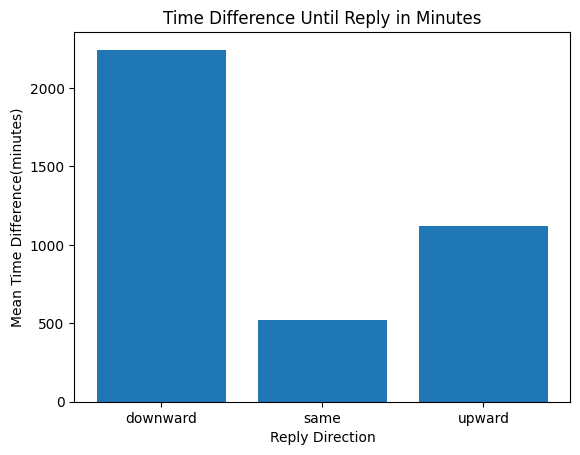

In [13]:
# Graph for group means

import matplotlib.pyplot as plt
means =df_result.groupby('reply_direction')['diff'].mean()
plt.bar(means.index, means.values)
plt.title('Time Difference Until Reply in Minutes')
plt.xlabel('Reply Direction')
plt.ylabel('Mean Time Difference(minutes)')
# plt.show()

plt.savefig('delta time reply.jpg', dpi=300)  